# 2021-12-21 Update Note

- Being discouraged by the low performance of transformer, and research, I will move back to "more" epoch.

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


- I will use xresnet and their datablock, optimizer from fastai.

In [2]:
!git clone https://github.com/fastai/course-v3/ /content/course-v3

Cloning into '/content/course-v3'...
remote: Enumerating objects: 5893, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 5893 (delta 0), reused 2 (delta 0), pack-reused 5890
Receiving objects: 100% (5893/5893), 263.03 MiB | 19.94 MiB/s, done.
Resolving deltas: 100% (3249/3249), done.


In [3]:
# restart-run
%cd /content/course-v3/nbs/dl2

/content/course-v3/nbs/dl2


- NOTE: if you do not have installed [nvidia/apex](https://github.com/nvidia/apex),  change `from exp.nb_10c import *` to `from exp.nb_10b import *` in `exp.nb_11`

In [51]:
from exp.nb_12a import *

- Local data (which is divided into separate dataset) is saved to `Path('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/data/v1/ser'`


In [5]:
root_path = Path('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/ser/data/v1'); root_path.ls()

[PosixPath('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/ser/data/v1/train'),
 PosixPath('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/ser/data/v1/dev'),
 PosixPath('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/ser/data/v1/ser.tar-v1.gz')]

features-entry contains a list of a list with 26 items.
- length of inner list: 26 (float numbers - represent one preprocessed speech frame (logMel))

- length of outer list: number of frames per data-point, e.g. 10 or 15, ...

In [13]:
train_path = root_path/'train'

In [7]:
# restart-run
audios = get_files(train_path)
class AudioList(ItemList):
    @classmethod
    def from_files(cls, path, extensions = None, recurse=True, include=None, **kwargs):
        return cls(get_files(path, extensions, recurse=recurse, include=include), path, **kwargs)
    
    def get(self, fn):
        return torch.load(fn)
        
# al=AudioList.from_files(train_path); al

In [ ]:
# al[0].shape, al[0].type()

(torch.Size([614, 26]), 'torch.FloatTensor')

In [8]:
class Reshape():
    _order=12
    def __call__(self, item):
        w, h = item.shape
        return item.view(h, w)

In [14]:
# Mutants of input tensor
class PadorTrim():
    
    _order = 20
    def __init__(self, max_len):
        self.max_len = max_len
    def __call__(self, ad):
        # h - logmel, here 27, w - frames / various
        h, w = ad.shape
        pad_size = self.max_len - w
        if pad_size >0: return torch.cat((ad, torch.zeros(h, pad_size).to(ad.device)), dim=1)
        else: return ad[:, :self.max_len]

In [15]:
class DummyChannel():
    _order = 30
    def __call__(self, item):
        return item.unsqueeze(0)

In [128]:
class SpecAugment():
    _order=99
    def __init__(self, max_mask_pct=0.2, freq_masks=1, time_masks=1, replace_with_zero=False):
        self.max_mask_pct, self.freq_masks, self.time_masks, self.replace_with_zero = \
        max_mask_pct, freq_masks, time_masks, replace_with_zero
        if not 0 <= self.max_mask_pct <= 1.0: 
            raise ValueError( f"max_mask_pct must be between 0.0 and 1.0, but it's {self.max_mask_pct}")

    def __call__(self, spec):
        _, n_mels, n_steps = spec.shape
        F = math.ceil(n_mels * self.max_mask_pct) # rounding up in case of small %
        T = math.ceil(n_steps * self.max_mask_pct)
        fill = 0 if self.replace_with_zero else spec.mean()
        for i in range(0, self.freq_masks):
            f = random.randint(0, F)
            f0 = random.randint(0, n_mels-f)
            spec[0][f0:f0+f] = fill
        for i in range(0, self.time_masks):
            t = random.randint(0, T)
            t0 = random.randint(0, n_steps-t)
            spec[0][:,t0:t0+t] = fill
        return spec

In [129]:
masker = SpecAugment(freq_masks=2, time_masks=2, max_mask_pct=0.1)

In [130]:
tfms = [Reshape(), PadorTrim(250), DummyChannel(), masker]

In [131]:
al=AudioList.from_files(train_path, tfms=tfms)

In [132]:
def re_labeler(fn, pat, subcl='act'):
    assert subcl in ['act', 'val', 'all']
    if subcl=='all': return ''.join(re.findall(pat, str(fn)))
    else:
        return re.findall(pat, str(fn))[0] if pat == 'act' else re.findall(pat, str(fn))[1]

label_pat = r'_(\d+)'
emotion_labeler = partial(re_labeler, pat=label_pat, subcl='all')

In [133]:
sd = SplitData.split_by_func(al, partial(random_splitter, p_valid=0.2))
ll = label_by_func(sd, emotion_labeler, proc_y=CategoryProcessor())

In [134]:
bs=64
c_in = ll.train[0][0].shape[0]
c_out = len(uniqueify(ll.train.y))
data = ll.to_databunch(bs,c_in=c_in,c_out=c_out)

In [135]:
ll.train[0][0].shape

torch.Size([1, 26, 250])

In [136]:
c_in, c_out

(1, 4)

In [138]:
opt_func = adam_opt(mom=0.9, mom_sqr=0.99, eps=1e-6, wd=1e-1, )
loss_func = LabelSmoothingCrossEntropy()
lr = 1e-2
pct_start = 0.5
phases = create_phases(pct_start)
sched_lr  = combine_scheds(phases, cos_1cycle_anneal(lr/10., lr, lr/1e5))
sched_mom = combine_scheds(phases, cos_1cycle_anneal(0.95,0.85, 0.95))
cbscheds = [ParamScheduler('lr', sched_lr), 
            ParamScheduler('mom', sched_mom)]

In [139]:
from sklearn.metrics import f1_score

def multi_f1score(input, target):
    with torch.no_grad():
        label_convert = {0:[1, 1], 1:[0, 0], 2:[1,0], 3:[0, 1]}
        pred_np = np.array(list(map(lambda o: label_convert[int(o)], input.argmax(1))))
        targ_np = np.array(list(map(lambda o: label_convert[int(o)], target)))
        # print(targ_np)
        return (f1_score(targ_np[:, 0], pred_np[:, 0]) + f1_score(targ_np[:, 1], pred_np[:, 1])) /2
# multi_f1score.__name__ = 'f1-score'

In [140]:
multi_f1score.__name__ = 'fscore'

In [141]:
from exp.nb_09b import *

In [142]:
class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats,self.valid_stats = AvgStats(metrics,True),AvgStats(metrics,False)

    def begin_fit(self):
        met_names = ['loss'] + [m.__name__ for m in self.train_stats.metrics]
        names = ['epoch'] + [f'train_{n}' for n in met_names] + [
            f'valid_{n}' for n in met_names] + ['time']
        self.logger(names)

    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        self.start_time = time.time()

    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        print(stats)
        with torch.no_grad(): stats.accumulate(self.run)

    def after_epoch(self):
        stats = [str(self.epoch)]
        for o in [self.train_stats, self.valid_stats]:
            stats += [f'{v:.6f}' for v in o.avg_stats]
        stats += [format_time(time.time() - self.start_time)]
        self.logger(stats)

In [143]:
class Learner():
    def __init__(self, model, data, loss_func, opt_func=sgd_opt, lr=1e-2, splitter=param_getter,
                 cbs=None, cb_funcs=None):
        self.model,self.data,self.loss_func,self.opt_func,self.lr,self.splitter = model,data,loss_func,opt_func,lr,splitter
        self.in_train,self.logger,self.opt = False,print,None

        # NB: Things marked "NEW" are covered in lesson 12
        # NEW: avoid need for set_runner
        self.cbs = []
        self.add_cb(TrainEvalCallback())
        self.add_cb(Recorder())
        # self.add_cb(LR_Find())
        self.add_cbs(cbs)
        self.add_cbs(cbf() for cbf in listify(cb_funcs))

    def add_cbs(self, cbs):
        for cb in listify(cbs): self.add_cb(cb)

    def add_cb(self, cb):
        cb.set_runner(self)
        setattr(self, cb.name, cb)
        self.cbs.append(cb)

    def remove_cbs(self, cbs):
        for cb in listify(cbs): self.cbs.remove(cb)

    def one_batch(self, i, xb, yb):
        try:
            self.iter = i
            self.xb,self.yb = xb,yb;                        self('begin_batch')
            self.pred = self.model(self.xb);                self('after_pred')
            self.loss = self.loss_func(self.pred, self.yb); self('after_loss')
            if not self.in_train: return
            self.loss.backward();                           self('after_backward')
            self.opt.step();                                self('after_step')
            self.opt.zero_grad()
        except CancelBatchException:                        self('after_cancel_batch')
        finally:                                            self('after_batch')

    def all_batches(self):
        self.iters = len(self.dl)
        try:
            for i,(xb,yb) in enumerate(self.dl): self.one_batch(i, xb, yb)
        except CancelEpochException: self('after_cancel_epoch')

    def do_begin_fit(self, epochs):
        self.epochs,self.loss = epochs,tensor(0.)
        self('begin_fit')

    def do_begin_epoch(self, epoch):
        self.epoch,self.dl = epoch,self.data.train_dl
        return self('begin_epoch')

    def fit(self, epochs, cbs=None, reset_opt=False):
        # NEW: pass callbacks to fit() and have them removed when done
        self.add_cbs(cbs)
        # NEW: create optimizer on fit(), optionally replacing existing
        if reset_opt or not self.opt: self.opt = self.opt_func(self.splitter(self.model), lr=self.lr)

        try:
            self.do_begin_fit(epochs)
            for epoch in range(epochs):
                self.do_begin_epoch(epoch)
                if not self('begin_epoch'): self.all_batches()

                with torch.no_grad():
                    self.dl = self.data.valid_dl
                    if not self('begin_validate'): self.all_batches()
                self('after_epoch')

        except CancelTrainException: self('after_cancel_train')
        finally:
            self('after_fit')
            self.remove_cbs(cbs)

    ALL_CBS = {'begin_batch', 'after_pred', 'after_loss', 'after_backward', 'after_step',
        'after_cancel_batch', 'after_batch', 'after_cancel_epoch', 'begin_fit',
        'begin_epoch', 'begin_epoch', 'begin_validate', 'after_epoch',
        'after_cancel_train', 'after_fit'}

    def __call__(self, cb_name):
        res = False
        assert cb_name in self.ALL_CBS
        for cb in sorted(self.cbs, key=lambda x: x._order): res = cb(cb_name) and res
        return res


In [144]:
def cnn_learner(arch, data, loss_func, opt_func, c_in=None, c_out=None,
                lr=1e-2, cuda=True, norm=None, progress=True, mixup=0, xtra_cb=None, **kwargs):
    cbfs = [partial(AvgStatsCallback,multi_f1score)]+listify(xtra_cb)
    if progress: cbfs.append(ProgressCallback)
    if cuda:     cbfs.append(CudaCallback)
    if norm:     cbfs.append(partial(BatchTransformXCallback, norm))
    if mixup:    cbfs.append(partial(MixUp, mixup))
    arch_args = {}
    if not c_in : c_in  = data.c_in
    if not c_out: c_out = data.c_out
    if c_in:  arch_args['c_in' ]=c_in
    if c_out: arch_args['c_out']=c_out
    return Learner(arch(**arch_args), data, loss_func, opt_func=opt_func, lr=lr, cb_funcs=cbfs, **kwargs)


In [148]:
learn = cnn_learner(xresnet50, data, loss_func, opt_func)

In [149]:
learn.cbs

In [150]:
learn.fit(5, cbs=cbscheds)

['epoch', 'train_loss', 'train_fscore', 'valid_loss', 'valid_fscore', 'time']



train: [1.4377012252807617, 0.5163288288288288]
train: [2.000795841217041, 0.535845645794752]
train: [1.9940147399902344, 0.595608583542134]
train: [1.9282273054122925, 0.6112161439781535]
train: [1.8740119934082031, 0.6142559340504473]
train: [1.8160196940104167, 0.6069857651478595]
train: [1.761850220816476, 0.5973347722702028]
train: [1.7484617233276367, 0.6086483515606034]
train: [1.6973618401421442, 0.6138191108522235]
train: [1.6796449661254882, 0.6104715978013993]
train: [1.6608472303910689, 0.6102988551441292]
train: [1.6504224141438801, 0.6096089673838019]
train: [1.635214585524339, 0.6104082775850479]
train: [1.6128924233572823, 0.6071395766608634]
train: [1.600351079305013, 0.6091410105187729]
train: [1.58870267868042, 0.6145870670883967]
train: [1.5900897979736328, 0.6108154186215481]
train: [1.5719113879733615, 0.6139683699519367]
train: [1.561904003745631, 0.615604559436006]
train: [1.5501294136047363, 0.6192297895538743]
train: [1.5381368001302083, 0.6225369064933575]
t

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))



valid: [2.7781753540039062, 0.4251152073732719]
valid: [2.8423633575439453, 0.4194416616576504]
valid: [3.0784594217936196, 0.42293441059404]
valid: [3.339387893676758, 0.43361692120540013]
valid: [3.186762809753418, 0.44004039011117324]
valid: [3.1095403035481772, 0.4470707244049832]
valid: [3.0696822575160434, 0.45329230056463526]
valid: [3.1430609226226807, 0.4529530870056277]
valid: [3.1926244099934897, 0.45493490774769246]
valid: [3.2447296142578126, 0.45469833396897064]
valid: [3.2783220464533027, 0.4553826975755815]
['0', '1.371317', '0.606991', '3.321879', '0.455953', '00:24']

train: [1.5157945156097412, 0.6683673469387754]
train: [1.5029711723327637, 0.6174375155467592]
train: [1.5144721666971843, 0.5639819127214084]
train: [1.4974889755249023, 0.5463838704384922]
train: [1.497042751312256, 0.5376199168636143]
train: [1.4682437578837078, 0.5426067342822714]
train: [1.4411239624023438, 0.5381998453503057]
train: [1.4476937055587769, 0.5412711850278379]
train: [1.4261017905341

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))



valid: [1.2676339149475098, 0.5256113797211127]
valid: [1.2962448596954346, 0.5311098200232598]
valid: [1.2920416196187336, 0.5172780314832355]
valid: [1.2937841415405273, 0.532741845381177]
valid: [1.273557758331299, 0.5259689312023477]
valid: [1.270081599553426, 0.5280510324122129]
valid: [1.2706234795706612, 0.5315227336642496]
valid: [1.2726699113845825, 0.5302455010983852]
valid: [1.2779799567328558, 0.5224134774568682]
valid: [1.275590705871582, 0.5193020427024805]
valid: [1.2756116173484109, 0.5148406331128758]
['2', '1.375111', '0.565948', '1.269967', '0.512669', '00:24']

train: [1.1103111505508423, 0.5028368794326241]
train: [1.2607805728912354, 0.45034317089910775]
train: [1.3125227292378743, 0.47935249193961144]
train: [1.260673999786377, 0.5021988678267679]
train: [1.2660486221313476, 0.4833124923196667]
train: [1.263841946919759, 0.5066650224257181]
train: [1.2654598781040736, 0.525788064334826]
train: [1.2610968351364136, 0.5468805753254866]
train: [1.2586905161539714, 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))



valid: [1.1776028871536255, 0.6718234981392877]
valid: [1.2109631299972534, 0.6336645580584079]
valid: [1.2156380812327068, 0.6346043077075881]
valid: [1.190412163734436, 0.6462041268380387]
valid: [1.1802141189575195, 0.6499330410904169]
valid: [1.1813205083211262, 0.6432912734092092]
valid: [1.1822780881609236, 0.6447991134716299]
valid: [1.1825690269470215, 0.6465411022481108]
valid: [1.1844523747762044, 0.6466050747683432]
valid: [1.179910659790039, 0.6515654518941029]
valid: [1.1750249862670898, 0.6492796509102546]
['4', '1.185362', '0.644592', '1.171733', '0.646482', '00:24']


In [151]:
def save_checkpoint(learner, filename):
    fname = Path(filename)
    fname.parent.mkdir(parents=True, exist_ok = True)
    checkpoint_dict = {
        'model': learn.model.state_dict(),
    }
    torch.save(checkpoint_dict, fname)

In [152]:
save_checkpoint(learn, '/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/ser/checkpoints/xtesnet50-5epochs.pt')

In [32]:
(root_path.parent.parent/'checkpoints').ls()

[PosixPath('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/ser/checkpoints/model-v5-8.tar.gz'),
 PosixPath('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/ser/checkpoints/.ipynb_checkpoints'),
 PosixPath('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/ser/checkpoints/2021-12-20-v2-2-transformer.pt'),
 PosixPath('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/ser/checkpoints/xtesnet34-20epochs.pt'),
 PosixPath('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/ser/checkpoints/xtesnet50-20epochs-f1:0.698.pt'),
 PosixPath('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/ser/checkpoints/xtesnet50-2epochs.pt')]

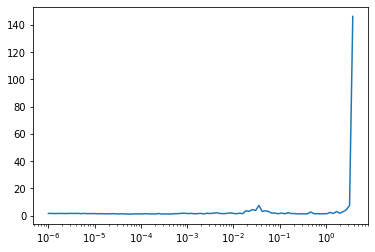

In [33]:
learn.recorder.plot()

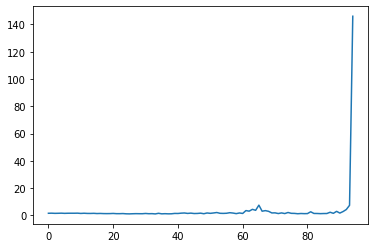

In [34]:
learn.recorder.plot_loss()

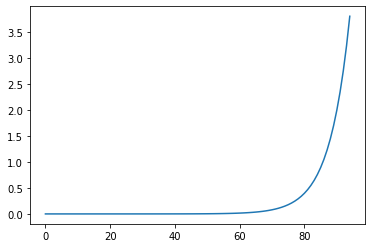

In [35]:
learn.recorder.plot_lr()

---

# Let me save the best model
1. measure metric and reserve the max values
2. when the max value changes, change the checkpoint model

# Let me interpret the results

In [153]:
def get_predictions(learn):
    learn.model.eval()
    targets, outputs = [],[]
    with torch.no_grad():
        for xb,yb in progress_bar(learn.data.valid_dl):
            out = learn.model(xb)
            for _,y,z in zip(xb,yb,out):
                targets.append(learn.data.train_ds.proc_y.deproc1(y))
                outputs.append(learn.data.train_ds.proc_y.deproc1(z.argmax(-1)))
    return targets, outputs

In [ ]:
trg, pred = get_predictions(learn)

In [ ]:
%cd /content

/content


In [ ]:
import seaborn as sn
import pandas as pd

In [ ]:
from IPython.display import display,HTML

In [ ]:
def cm(true_label, pred_label, clf):
    """
    The function not only calculates confusion matrix, but also visualizes (i.e. sys out write) it as heatmap
    Parameters
    ----------
    true_label : array-like of shape (n_samples,)
        Ground truth of target data
    pred_label : array-like of shape (n_samples,)
        Predictoin from target data
    labels: array-like of shape (n_classes), default=None
        labels which index confusion matrix
    Note
    ----------
    Please be sure that input is 1-D
    """
    cm_score = confusion_matrix(true_label, pred_label)
    df_cm = pd.DataFrame(cm_score, index=clf.labels, columns=clf.labels)
    display(HTML(df_cm.to_html()))

    plt.figure(figsize=(10, 7))
    sn.heatmap(df_cm, annot=True, fmt='d')
    img_path = Path('/content/results/cm')
    img_path.mkdir(exist_ok=True, parents=True)
    fname = img_path / f'ser_{clf.model.name}_epochs:{clf.epochs}'
    plt.savefig(fname)
    print(f"Your confusion matrix is saved at : {str(img_path)} named {fname}")

,"(act:0, val:1)","(act:0, val:0)","(act:1, val:1)","(act:1, val:0)"
"(act:0, val:1)",92,45,45,77
"(act:0, val:0)",42,39,24,96
"(act:1, val:1)",37,47,351,215
"(act:1, val:0)",37,47,138,242


Your confusion matrix is saved at : /content/results/cm named /content/results/cm/ser_xresnet50_epochs:30


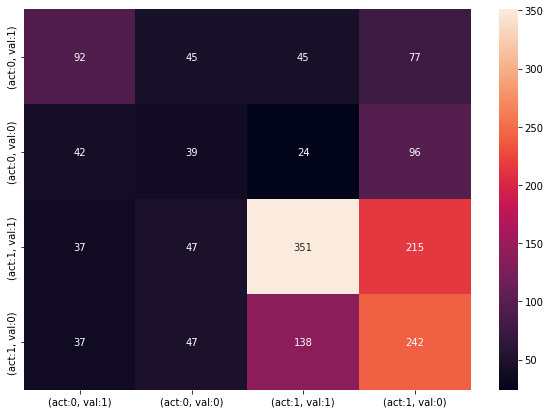

In [ ]:
cm(trg, pred, learn)

In [ ]:
learn.model.name = 'xresnet50'

In [ ]:
learn.labels = {'(act:1, val:1)','(act:0, val:0)', '(act:1, val:0)', '(act:0, val:1)'}

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(trg, pred))

              precision    recall  f1-score   support

          00       0.44      0.36      0.39       259
          01       0.22      0.19      0.21       201
          10       0.63      0.54      0.58       650
          11       0.38      0.52      0.44       464

    accuracy                           0.46      1574
   macro avg       0.42      0.40      0.41      1574
weighted avg       0.47      0.46      0.46      1574



In [ ]:
import numpy as np

In [ ]:
print(classification_report(true_act, pred_act))

              precision    recall  f1-score   support

           0       0.56      0.47      0.52       460
           1       0.80      0.85      0.82      1114

    accuracy                           0.74      1574
   macro avg       0.68      0.66      0.67      1574
weighted avg       0.73      0.74      0.73      1574



In [ ]:
print(classification_report(true_val, pred_val))

              precision    recall  f1-score   support

           0       0.69      0.58      0.63       909
           1       0.52      0.64      0.58       665

    accuracy                           0.60      1574
   macro avg       0.61      0.61      0.60      1574
weighted avg       0.62      0.60      0.61      1574



# submission - load and predict

In [ ]:
path2= Path('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/ser/')
upload_path =path2/'uploads'
upload_path.mkdir(exist_ok=True)

In [ ]:
tfms = [Reshape(), PadorTrim(250), DummyChannel()]

In [ ]:
st = torch.load('/content/checkpoints/xtesnet50-20epochs-f1:0.698.pt')

In [ ]:
st.keys()

dict_keys(['model'])

In [ ]:
learn.model.load_state_dict(st['model'])

<All keys matched successfully>

In [ ]:
dev_path = (path2/'data/v1/dev')
# audios = get_files(dev_path)
class AudioList(ItemList):
    @classmethod
    def from_files(cls, path, extensions = None, recurse=True, include=None, **kwargs):
        return cls(get_files(path, extensions, recurse=recurse, include=include), path, **kwargs)
    
    def get(self, fn):
        return torch.load(fn)
        
al=AudioList.from_files(dev_path, tfms=tfms)

In [ ]:
testset=torch.cat([al[idx] for idx, _ in enumerate(al.items)], dim=0)
testset.shape

torch.Size([3342, 26, 250])

In [ ]:
def get_predictions(learn, dev):
    test_n = dev.shape[0]
    learn.model.eval()
    res = []
    with torch.no_grad():        
        for i in range((test_n-1)//bs + 1):
            xb = dev[i*bs:(i+1)*bs]
            out = learn.model(xb)
            res += [o.item() for o in out.argmax(1)]
    return res

In [ ]:
res = get_predictions(learn, testset.unsqueeze(1))

In [ ]:
len(res)

3342

In [ ]:
ser_path  =Path("/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/ser/")

In [ ]:
(ser_path).exists()

True

In [ ]:
import json
with open(ser_path/'data/v0/ser-dev.json') as f: dev_json = json.load(f)

In [ ]:
len(dev_json)

3342

In [ ]:
(ser_path/'checkpoints').ls()

[PosixPath('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/ser/checkpoints/v2.1.pkl'),
 PosixPath('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/ser/checkpoints/.ipynb_checkpoints'),
 PosixPath('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/ser/checkpoints/xtesnet34-20epochs.pt'),
 PosixPath('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/ser/checkpoints/xtesnet50-20epochs-f1:0.698.pt')]

In [ ]:
!cp '/content/checkpoints/xtesnet50-20epochs-698f1score.pt' /gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/ser/checkpoints

cp: cannot stat '/content/checkpoints/xtesnet50-20epochs-698f1score.pt': No such file or directory


---

# Converting the format

In [ ]:
def get_serial(): return ''.join(str(i) for i in np.random.randint(0, 9, 10).tolist())

In [ ]:
my_serial = get_serial()

In [ ]:
label_dicts = {0:(1, 1), 1:(0, 0), 2:(1,0), 3:(0, 1)}

In [ ]:
res_dict = {str(i): label_dicts[o] for i, o in enumerate(res)}